In [1]:
%load_ext autoreload
%autoreload 2
%env CUDA_VISIBLE_DEVICES=1
import matplotlib.pyplot as plt
from utils.utils import get_path
from utils.pd_utils import get_persistent_feature_id
from utils.io_utils import load_multiple_res, dist_kwargs_to_str
from utils.dist_utils import get_dist, get_sknn, compute_effective_resistance
from utils.fig_utils import plot_edges_on_scatter
from utils.toydata_utils import get_toy_data
from vis_utils.plot import plot_scatter
import os
import numpy as np
from sklearn.decomposition import PCA
from sklearn.manifold import MDS
import scipy.sparse as sp

env: CUDA_VISIBLE_DEVICES=1


In [2]:
style_file = "utils.style"
plt.style.use(style_file)
root_path = get_path("data")
fig_path = os.path.join(root_path, "figures")

# Figure for intuition about robustness of geodesic distance and effective resistance

In [3]:
k = 15
n = 1000
nbs_random = [0, 10] 
seed = 1
sigma = 0.1

data = get_toy_data(n=n, dataset ="toy_circle", d=2, seed=seed, gaussian={"sigma": sigma})
sknn = get_sknn(data, k=k)

In [4]:
res = {}


for n_random in nbs_random:
    sknn = get_sknn(data, k=k)
    np.random.seed(seed)
    heads, tails = np.random.choice(data.shape[0], size=n_random), np.random.choice(data.shape[0], size=n_random)
    
    sknn.data = np.concatenate([sknn.data, np.ones(n_random*2)])
    sknn.row = np.concatenate([sknn.row, heads, tails])
    sknn.col = np.concatenate([sknn.col, tails, heads])
    
    # handle possible duplicates among the added edges:
    sknn.sum_duplicates()
    sknn.data = np.ones_like(sknn.data)
    
    
    #dist = get_dist(data, "eff_res", k=k, corrected="False")
    dist  = compute_effective_resistance(sknn, disconnect=True)
    
    degs = np.array(sknn.sum(axis=1))
    deg_dist = 1/degs + 1/degs.T
    np.fill_diagonal(deg_dist, 0)
    dist_eff_res = dist - deg_dist + 2*sknn.toarray() / (degs * degs.T)
        
    sknn_csr = sknn.tocsr()
    dist_geo = sp.csgraph.shortest_path(sknn_csr, directed=False)
    
    res[n_random] = {"graph": sknn, "heads": heads, "tails": tails, "dist_eff_res": dist_eff_res, "dist_geo": dist_geo}

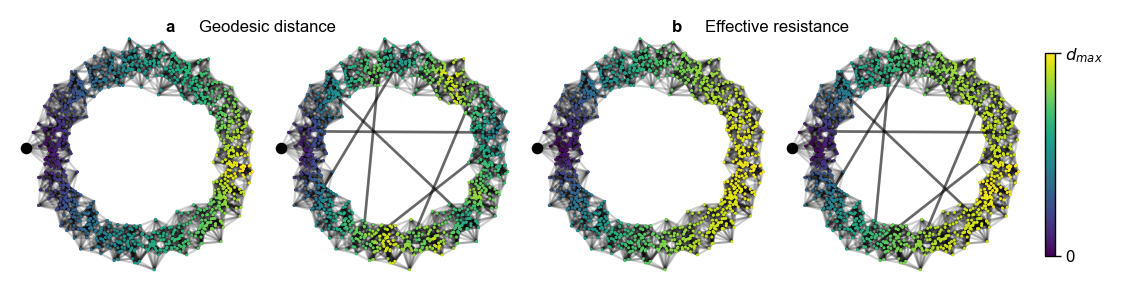

In [5]:
fig, ax = plt.subplots(1, 4, figsize=(5.5, 1.35))


pt_id = np.argmin(data[:, 0])
dist_key = ["dist_geo", "dist_eff_res"]

letters = "abcdef"

titles = ["Geodesic distance", "Effective resistance"]

for i in range(2):
    for j, n_random in enumerate(nbs_random):
        cax = ax[2*i+j]
        
        scatter = cax.scatter(*data.T, c = res[n_random][dist_key[i]][pt_id], cmap="viridis", s=5, zorder=10, edgecolor="none")
        cax.scatter(data[pt_id, 0], data[pt_id, 1], c="k", s=10, marker="o", zorder=11, clip_on=False)
        cax.set_aspect('equal', 'datalim')
        cax.axis("off")
        
        # plot edges
        edges = np.moveaxis(np.stack([res[n_random]["graph"].row,
                                     res[n_random]["graph"].col]),
                            0, 1)
        plot_edges_on_scatter(cax, edges, x=data, color="k", linewidth=0.75, alpha=0.1, zorder=0
                              )
        random_edges = np.moveaxis(np.stack([res[n_random]["heads"], res[n_random]["tails"]]), 0, 1)
        plot_edges_on_scatter(cax, random_edges, x=data, color="k", linewidth=1, alpha=0.5, zorder=0)
        
left = 0.14
right = 0.6
gap = 0.03
height = 0.97

fig.text(left, height, 'a', ha='left', va='center', fontweight="bold", clip_on=False)
fig.text(right, height, 'b', ha='left', va='center', fontweight="bold", clip_on=False)
fig.text(left+gap, height, titles[0], ha='left', va='center', clip_on=False)
fig.text(right+gap, height, titles[1], ha='left', va='center', clip_on=False)

cbar= fig.colorbar(scatter, ax=ax, shrink=0.8, pad=0.02 )
cbar.ax.set_yticks([0, res[10]["dist_eff_res"][pt_id].max()]) 
cbar.ax.set_yticklabels(["0", "$d_{max}$"]) 

fig.savefig(os.path.join(fig_path, f"circle_sigma_{sigma}_n_{n}_k_{k}_random_{nbs_random[0]}_{nbs_random[1]}_seed_{seed}_dist_geo_eff_res.png"), dpi=300)
fig.savefig(os.path.join(fig_path, f"circle_sigma_{sigma}_n_{n}_k_{k}_random_{nbs_random[0]}_{nbs_random[1]}_seed_{seed}_dist_geo_eff_res.pdf"), dpi=300)